In [25]:
import numpy as np
import scipy.io
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from itertools import product
import random
from tqdm import trange

In [26]:
# Set random seed for full reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

In [27]:
# Load the saved file with the best model and its configuration
checkpoint = torch.load('best_model.pth')
# Extract saved data
best_config = checkpoint['config']  # (n_steps, lr, hidden_sizes, drop_out)

In [28]:
# Load data
mat = scipy.io.loadmat('Xtrain.mat')
data = mat['Xtrain'].flatten().reshape(-1, 1) 

# Normalize
scaler = MinMaxScaler()
scaled = scaler.fit_transform(data)

# Create window sequences
def create_dataset(series, n_steps):
    X, y = [], []
    for i in range(len(series) - n_steps):
        X.append(series[i:i + n_steps].flatten())
        y.append(series[i + n_steps])
    return np.array(X), np.array(y)

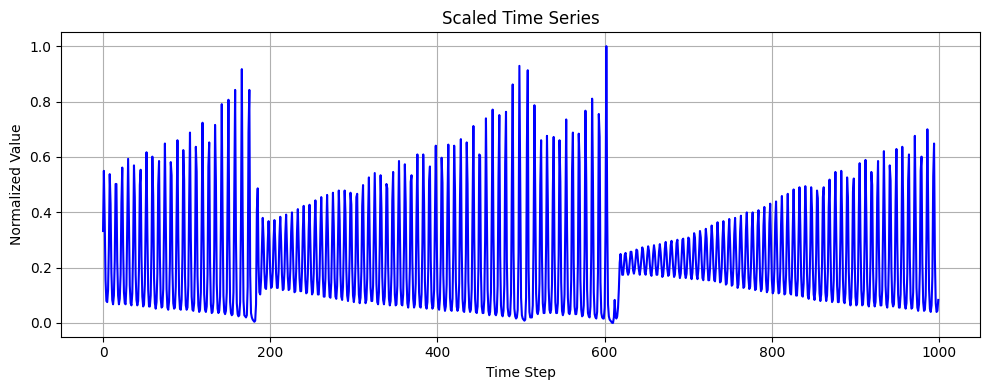

In [29]:
# Plot the scaled data
plt.figure(figsize=(10, 4))
plt.plot(scaled, color='blue')
plt.title('Scaled Time Series')
plt.xlabel('Time Step')
plt.ylabel('Normalized Value')
plt.grid(True)
plt.tight_layout()
plt.show()

In [30]:
class FeedForwardNN(nn.Module):
    def __init__(self, input_size, hidden_sizes, dropout_rate=0.2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, hidden_sizes[0]),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_sizes[0], hidden_sizes[1]),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_sizes[1], 1)
        )

    def forward(self, x):
        return self.net(x)

In [31]:
# --- Training Function ---
def train_model(model, criterion, optimizer, X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor,
                max_epochs=150, patience=5, min_delta=1e-4):
    best_loss = float('inf')
    epochs_no_improve = 0
    train_losses = []
    val_losses = []

    for epoch in range(max_epochs):
        model.train()
        optimizer.zero_grad()
        y_pred = model(X_train_tensor)
        loss = criterion(y_pred, y_train_tensor)
        loss.backward()
        optimizer.step()

        model.eval()
        with torch.no_grad():
            val_pred = model(X_val_tensor)
            val_loss = criterion(val_pred, y_val_tensor)

        train_losses.append(loss.item())
        val_losses.append(val_loss.item())

        if val_loss.item() < best_loss - min_delta:
            best_loss = val_loss.item()
            best_state = model.state_dict()
            best_train = train_losses.copy()
            best_val = val_losses.copy()
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            break

    return best_loss, best_state, best_train, best_val

In [32]:
# 1. Unpack the best configuration
n_steps, lr, hidden_sizes, dropout_rate = best_config

# 2. Create full dataset using best n_steps
X, y = create_dataset(scaled, n_steps)

# 3. Convert to PyTorch tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32).view(-1, 1)

# 4. Initialize the final model
final_model = FeedForwardNN(n_steps, hidden_sizes, dropout_rate)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(final_model.parameters(), lr=lr)

# 5. Train on full data (no validation used here)
_, final_state, full_train_losses, _ = train_model(
    final_model, criterion, optimizer,
    X_tensor, y_tensor,  # Used as both "train" and "val"
    X_tensor, y_tensor,  # Just to reuse train_model function
    max_epochs=150
)

# 6. Load the best weights from final training
final_model.load_state_dict(final_state)
final_model.eval()


FeedForwardNN(
  (net): Sequential(
    (0): Linear(in_features=50, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.0, inplace=False)
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.0, inplace=False)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

In [33]:
torch.save({
    'model_state_dict': final_model.state_dict(),
    'config': best_config,
    'train_loss': full_train_losses
}, 'final_model.pth')

In [34]:
# 1. Minimum MSE from training
min_mse_scaled = min(full_train_losses)

# 2. Scaled RMSE
rmse_scaled = min_mse_scaled**0.5

# 3. Unscaled RMSE (MinMaxScaler range)
range_ = scaler.data_max_ - scaler.data_min_
rmse_unscaled = rmse_scaled * range_[0]  # [0] to extract scalar from array

# 4. Print results
print(f"Minimum Scaled Train Loss (MSE): {min_mse_scaled:.6f}")
print(f"Scaled RMSE: {rmse_scaled:.6f}")
print(f"Unscaled RMSE: {rmse_unscaled:.6f}")

Minimum Scaled Train Loss (MSE): 0.000866
Scaled RMSE: 0.029433
Unscaled RMSE: 7.446625


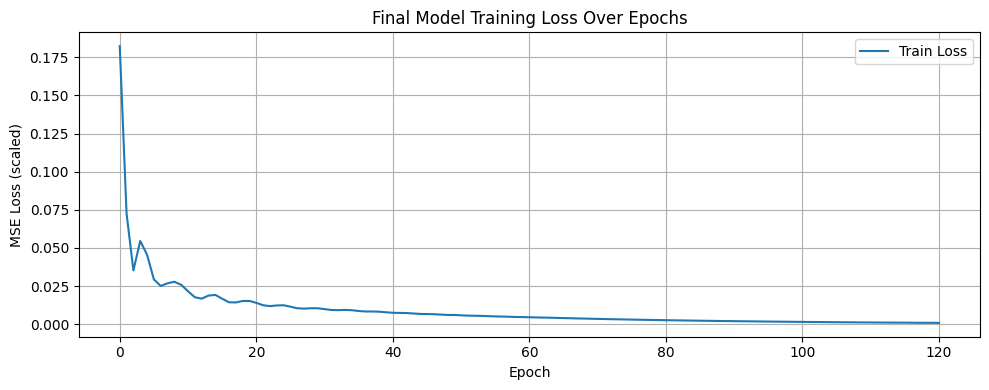

In [35]:
# Plot training loss over epochs
plt.figure(figsize=(10, 4))
plt.plot(full_train_losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss (scaled)')
plt.title('Final Model Training Loss Over Epochs')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

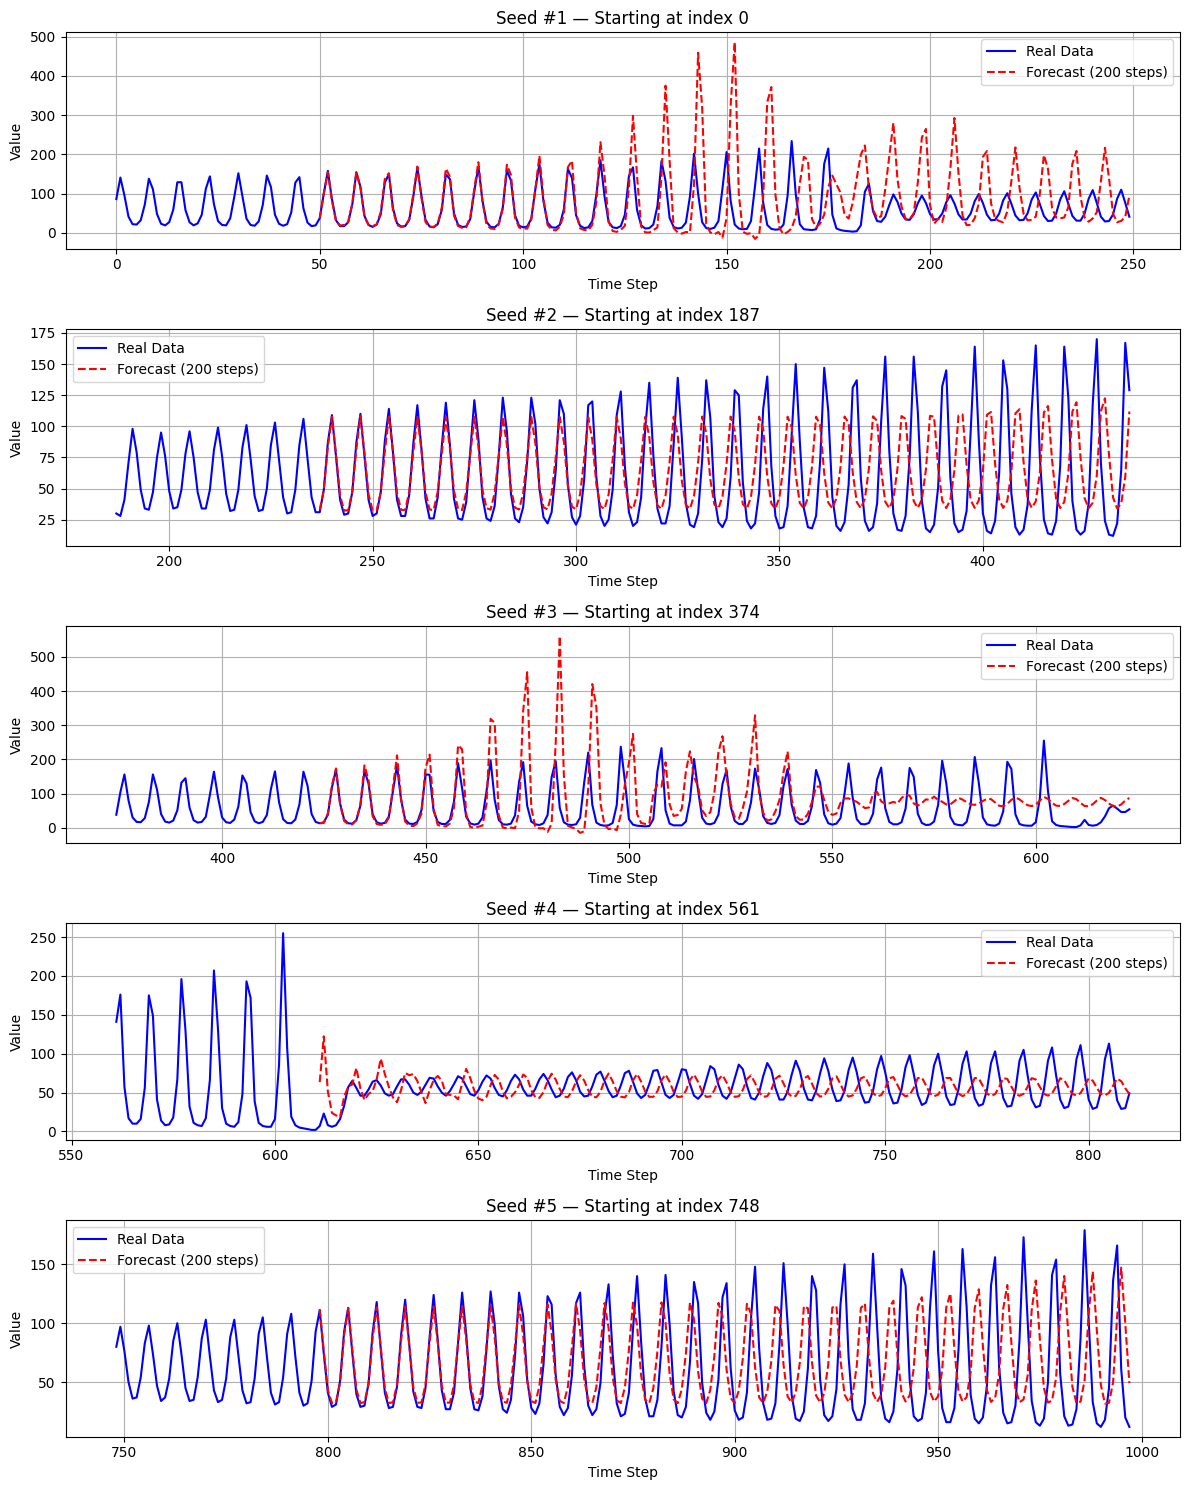

In [36]:
import matplotlib.pyplot as plt

# Function to recursively forecast from a given seed
def recursive_forecast(model, seed_seq, n_future, scaler):
    model.eval()
    forecast = []
    input_seq = seed_seq.copy()

    for _ in range(n_future):
        input_tensor = torch.tensor(input_seq, dtype=torch.float32).view(1, -1)
        with torch.no_grad():
            next_val = model(input_tensor).item()
        forecast.append(next_val)
        input_seq = input_seq[1:] + [next_val]

    forecast = scaler.inverse_transform(np.array(forecast).reshape(-1, 1))
    return forecast.flatten()

# Choose 5 seed starting points evenly across the data
total_len = len(scaled)
step_size = (total_len - n_steps - 200) // 4  # spacing to allow 200-step forecast
start_indices = [i * step_size for i in range(5)]

# Plot
plt.figure(figsize=(12, 15))

for i, idx in enumerate(start_indices):
    seed = scaled[idx:idx + n_steps].flatten().tolist()
    forecast = recursive_forecast(final_model, seed, n_future=200, scaler=scaler)

    # Real data for comparison
    real_start = idx
    real_end = idx + n_steps + 200
    real_subsection = scaler.inverse_transform(scaled[real_start:real_end])

    # Axis
    x_real = np.arange(real_start, real_start + len(real_subsection))
    x_pred = np.arange(real_start + n_steps, real_start + n_steps + 200)

    # Subplot
    plt.subplot(5, 1, i + 1)
    plt.plot(x_real, real_subsection, label='Real Data', color='blue')
    plt.plot(x_pred, forecast, label='Forecast (200 steps)', color='red', linestyle='--')
    plt.title(f'Seed #{i+1} — Starting at index {idx}')
    plt.xlabel('Time Step')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()
